In [21]:
import tensorflow
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np

In [2]:
file_names = []
scores = []
for file_name in os.listdir("./Images"):
    file_names.append(file_name)
    scores.append(round(float(file_name[0:4])*100,1))
d = {"File Name": file_names, "Score": scores}
df = pd.DataFrame(d)

In [4]:
df = df.sample(frac=1)
df.head()

,File Name,Score
6434,0.18 vasiliki_georgiadi25010868_15089852889086...,18.0
4767,0.13 nikiskiadaresi46127593_580380889079833_53...,13.0
4396,0.12 georgiafowler39507591_273879473435065_348...,12.0
4297,0.12 102559326_3125200530833324_32399063311936...,12.0
7151,0.21 georgiafowler47459602_2231415600474253_60...,21.0


In [5]:
df.count()

File Name    18523
Score        18523
dtype: int64

In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.02)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

In [9]:
dataGen = ImageDataGenerator(
  zoom_range = 0.1,
  rotation_range = 5)

testGen = ImageDataGenerator()

In [10]:
train_gen = dataGen.flow_from_dataframe (train,directory="./Images",x_col="File Name",y_col="Score",
    target_size=(500, 500),
    classes=None,
    class_mode="raw",
    batch_size=32,
    shuffle=True)

test_gen = testGen.flow_from_dataframe (test,directory="./Images",x_col="File Name",y_col="Score",
    target_size=(500, 500),
    classes=None,
    class_mode="raw")

Found 18152 validated image filenames.
Found 371 validated image filenames.


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [12]:
# Todo: z-transform, initiallization of weights
input = keras.Input(shape=(500,500,3))
x = layers.experimental.preprocessing.Rescaling(1./255)(input)
x = layers.Conv2D(16, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)
output = layers.Dense(1, activation="linear")(x)

model = keras.Model(input,output)

In [13]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 500, 500, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 498, 498, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 249, 249, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 247, 247, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 121, 121, 64)     

In [14]:
model.compile(loss ="mean_squared_error",optimizer = Adam())

reduce_lr = ReduceLROnPlateau(monitor='loss', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=0.0005)

early_stop = EarlyStopping(
    monitor="loss",
    min_delta=0.01,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [15]:
results = model.evaluate(test_gen)
print("Mean Average Loss before training", results)

12/12 [==============================] - 85s 7s/step - loss: 1545.1927
Mean Average Loss before training 1545.1927490234375


In [34]:
def show_random_images(rows, cols):
    fig, axs = plt.subplots(rows, cols)
    fig.subplots_adjust(top = 0.7, bottom=0.01, hspace=0.5, wspace=0.4)
    fig.set_figheight(12)
    fig.set_figwidth(12)
    preds = model.predict(test_gen[0][0])
    for i in range(rows):
        for j in range(cols):
            x = random.randint(0,len(test_gen[0][0])-1)
            image = test_gen[0][0][x]/255
            axs[i,j].imshow(image)
            axs[i,j].axis('off')
            axs[i,j].set_title("Real {}".format(test_gen[0][1][x],color="blue"))

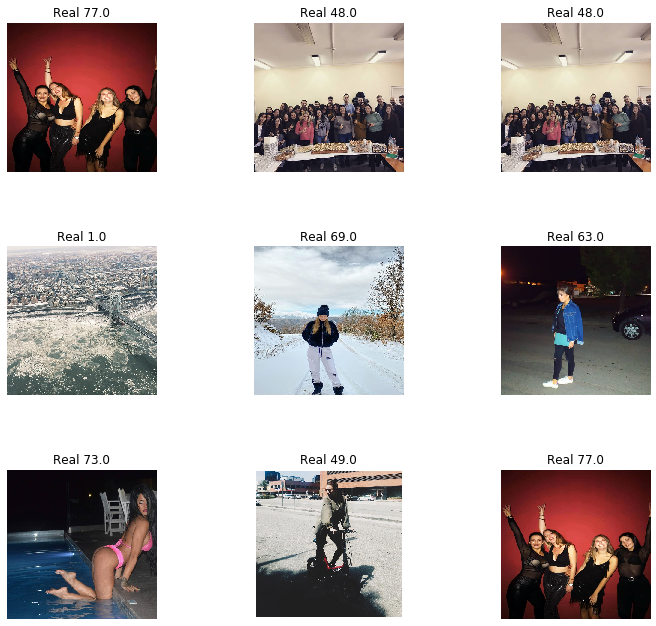

In [35]:
show_random_images(3,3)